# 01 – EDA

La mision general es realizar un assestment de:
- Data quality
- Imbalance
- Feature signals
- Time trends

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score, average_precision_score

In [26]:
# Configs
pd.set_option("display.max_columns", None)
warnings.filterwarnings("ignore") # por dejarlo mas prolijo, obvio en un escenario real las soluciono.

In [8]:
# Importamos la data y creamos punteros a las features clave no anonimizadas y nuestro target.
DATA_PATH = "./MeLiFraud.csv"
TARGET_COL = "fraude"
AMOUNT_COL = "monto"
DATE_COL = "fecha"
SCORE_COL = "score"

df = pd.read_csv(DATA_PATH)
df.head()

,a,b,c,d,e,f,g,h,j,k,l,m,n,o,p,fecha,monto,score,fraude
0,4,0.6812,50084.12,50.0,0.000000,20.0,AR,1,cat_d26ab52,0.365475,2479.0,952.0,1,NaN,Y,2020-03-20 09:28:19,57.63,100,0
1,4,0.6694,66005.49,0.0,0.000000,2.0,AR,1,cat_ea962fb,0.612728,2603.0,105.0,1,Y,Y,2020-03-09 13:58:28,40.19,25,0
2,4,0.4718,7059.05,4.0,0.463488,92.0,BR,25,cat_4c2544e,0.651835,2153.0,249.0,1,Y,Y,2020-04-08 12:25:55,5.77,23,0
3,4,0.7260,10043.10,24.0,0.046845,43.0,BR,43,cat_1b59ee3,0.692728,4845.0,141.0,1,N,Y,2020-03-14 11:46:13,40.89,23,0
4,4,0.7758,16584.42,2.0,0.154616,54.0,BR,0,cat_9bacaa5,0.201354,2856.0,18.0,1,Y,N,2020-03-23 14:17:13,18.98,71,0


## 0) Setup

In [10]:
print("Shape:", df.shape)
display(df.dtypes)

# Date parsing and coverage
if DATE_COL in df.columns:
    try:
        df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")
        date_min, date_max = df[DATE_COL].min(), df[DATE_COL].max()
        print("Date coverage:", date_min, "->", date_max)
    except Exception as e:
        print("Date parse error:", e)

Shape: (150000, 19)


a           int64
b         float64
c         float64
d         float64
e         float64
f         float64
g          object
h           int64
j          object
k         float64
l         float64
m         float64
n           int64
o          object
p          object
fecha      object
monto     float64
score       int64
fraude      int64
dtype: object

Date coverage: 2020-03-08 00:02:15 -> 2020-04-21 23:59:56


> ### Observaciones – Setup

Tenemos **150,000 registros** y **19 columnas**.  
Las variables son anónimas por politicas de la empresa, aunque se reconoce:

- **fecha**: rango del 08-03-2020 al 21-04-2020 (~1.5 meses de data).
- **monto**: valor monetario de la transaccion.
- **score**: puntaje interno (0–100).
- **fraude**: variable objetivo binaria (0/1).

El resto de las columnas (`a–p`) representan features numericos y categoricos sin descripcion directa, por lo que se analizaran de manera exploratoria.  
El periodo para el cual contamos con datos es relativamente corto, lo que sugiere que puede haber **sesgos estacionales o picos de fraude** que deberan ser evaluados en la seccion de tendencias de tiempo (Time trends).

## 1) Null exploration

In [24]:
# Presencia de nulos: cantidad y porcentaje
null_counts = df.isna().sum().sort_values(ascending=False)
null_percent = (df.isna().mean().sort_values(ascending=False) * 100).round(2)
null_table = pd.concat([null_counts.rename("null_count"), null_percent.rename("null_%")], axis=1)
display(null_table)

# Buscamos nulos en nuestra variable objetivo (sanity)
if TARGET_COL in df.columns:
    print("Target nulls:", df[TARGET_COL].isna().sum())

# Agrupamos nulos globales segun valores de nuestro objetivo
if TARGET_COL in df.columns:
    grp = df.groupby(TARGET_COL).apply(lambda x: x.isna().sum()).T
    grp.columns = [f"nulls_when_{TARGET_COL}={c}" for c in grp.columns]
    display(grp)

,null_count,null_%
o,108857,72.57
c,12984,8.66
b,12984,8.66
d,365,0.24
m,365,0.24
g,194,0.13
f,11,0.01
l,11,0.01
a,0,0.00
score,0,0.00


Target nulls: 0


,nulls_when_fraude=0,nulls_when_fraude=1
a,0,0
b,12155,829
c,12155,829
d,336,29
e,0,0
f,11,0
g,179,15
h,0,0
j,0,0
k,0,0


> ### Observaciones – Nulos

  - La variable **`o`** tiene ~72% de valores faltantes.  
  - Las variables **`b`** y **`c`** rondan el 8.6% de nulos.  
  - El resto de columnas muestra porcentajes despreciables (<0.3%).  

- La variable objetivo **`fraude`** no tiene nulos, excelente.  

- Al agrupar por target:  
  - Tanto en **fraude=0** como en **fraude=1** se mantienen los mismos patrones de nulos. No parece haber un sesgo de missingness concentrado solo en los casos de fraude/no fraude.

- Conclusiones preliminares:  
  - La columna **`o`** probablemente requiera descarte debido a tanta data faltante y ser anonima, al no conocer el bloque de informacion que representa, en este estadio y contexto su imputacion resulta risky business.
  - Para `b` y `c`, se puede explorar imputacion.
  - Las variables **`b` y `c`** destacan porque presentan **exactamente el mismo numero de nulos**, tanto en total como al agruparse por la variable objetivo. Esto sugiere que ambas provienen de la misma fuente o proceso de captura, y que la ausencia de valores ocurre de manera conjunta. Hipotesis: podrian ser features correlacionadas o derivadas de un mismo calculo/proceso, lo que tambien implicaria riesgo de multicolinealidad, por esto el approach sera analizarlas en conjunto durante el modelado y evaluar si una de las dos puede descartarse sin perdida de informacion (de comprobarse una relacion tan estrecha que lo permita).
  
  - No hay riesgo de perder la señal de la variable objetivo por nulos.


## 2) Data quality / consistency checks


Column: g (top 20 uniques)


g
BR     111628
AR      31964
UY       2967
US       2273
SE        358
MX        236
NaN       194
RU         73
ES         69
CO         64
GB         43
FR         18
IT         14
PT         13
DE          9
CL          9
PE          5
EC          4
PY          4
UA          3
Name: count, dtype: int64


Column: j (top 20 uniques)


j
cat_43b9c10    2331
cat_d69bed9    1799
cat_604df77    1784
cat_6c4cfdc    1449
cat_4249bd8    1191
cat_3203c7c    1093
cat_be0af8e    1040
cat_0820fab     938
cat_8ef7164     909
cat_d5975ae     878
cat_f0ec611     775
cat_960e53d     755
cat_0eb83e7     748
cat_e600e6d     709
cat_ffe7351     684
cat_ec06c68     662
cat_381751d     656
cat_0f47e2a     649
cat_9bacaa5     641
cat_2d99b60     617
Name: count, dtype: int64


Column: o (top 20 uniques)


o
NaN    108857
Y       24091
N       17052
Name: count, dtype: int64


Column: p (top 20 uniques)


p
Y    83129
N    66871
Name: count, dtype: int64


Value counts for binary candidate 'o':


o
NaN    108857
Y       24091
N       17052
Name: count, dtype: int64

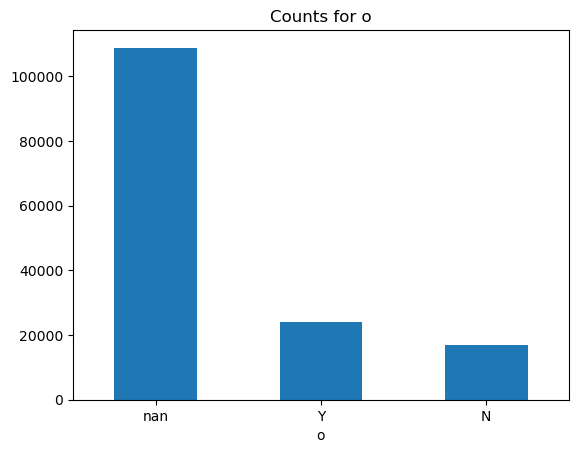


Value counts for binary candidate 'p':


p
Y    83129
N    66871
Name: count, dtype: int64

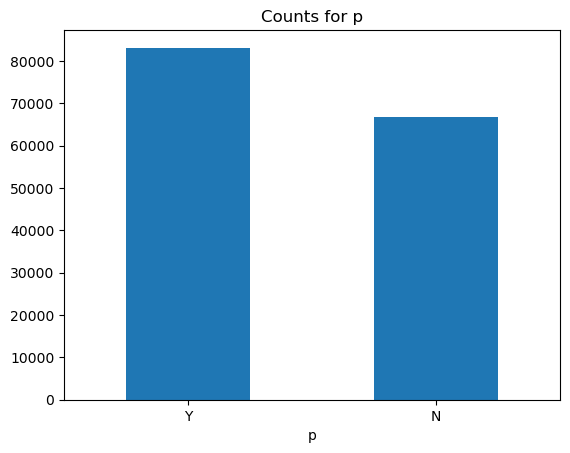

,count,mean,std,min,25%,50%,75%,max
a,150000.0,3.705407,0.753206,1.000000,4.000000,4.000000,4.000000,4.000000e+00
b,137016.0,0.728115,0.132943,0.000000,0.678400,0.755500,0.806500,1.000000e+00
c,137016.0,260445.107044,846436.141626,0.160000,9679.915000,43711.655000,145443.627500,1.387874e+07
d,149635.0,21.677669,20.062146,0.000000,2.000000,14.000000,50.000000,5.000000e+01
e,150000.0,0.220641,2.434995,0.000000,0.000000,0.104875,0.282938,8.333333e+02
f,149989.0,51.169352,709.472904,-5.000000,1.000000,8.000000,33.000000,1.452740e+05
h,150000.0,14.193513,14.161216,0.000000,3.000000,9.000000,21.000000,5.800000e+01
k,150000.0,0.497532,0.288348,0.000004,0.246819,0.495990,0.746508,9.999948e-01
l,149989.0,2305.409403,1712.379601,0.000000,910.000000,1937.000000,3445.000000,7.544000e+03
m,149635.0,299.969579,321.075806,0.000000,42.000000,193.000000,459.000000,2.225000e+03


Negative amounts: 0
Score min/max: 0 100
Duplicate rows: 0


In [33]:
# Categorical-like features
cat_like = df.select_dtypes(include=["object"]).columns.tolist()

# Valores unicos (top 20) categorical-like
for col in cat_like:
    vc = df[col].value_counts(dropna=False).head(20)
    print(f"\nColumn: {col} (top 20 uniques)")
    display(vc)

# Flags binarios value count
for col in ["o", "p"]:
    if col in df.columns:
        print(f"\nValue counts for binary candidate '{col}':")
        display(df[col].value_counts(dropna=False))
        plt.figure()
        df[col].value_counts(dropna=False).plot(kind="bar", rot=0)
        plt.title(f"Counts for {col}")
        plt.show()

# Checks numericos
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if AMOUNT_COL in df.columns and AMOUNT_COL not in num_cols:
    num_cols.append(AMOUNT_COL)

if num_cols:
    desc = df[num_cols].describe().T
    display(desc)

# Checks intuitivos sobre features con info conocida
if AMOUNT_COL in df.columns:
    print("Negative amounts:", (df[AMOUNT_COL] < 0).sum())
if SCORE_COL in df.columns:
    print("Score min/max:", df[SCORE_COL].min(), df[SCORE_COL].max())

# Duplicados
print("Duplicate rows:", df.duplicated().sum())

> ### Observaciones – Calidad y consistencia de datos

- **Variables categoricas**
  - `g` representa paises: predominan **BR** (111k) y **AR** (31k), seguidos de valores mucho menores.  
  - Se detectan **194 casos NaN** en `g`. Muy probablemente a dropear.
  - La distribucion tan concentrada en AR y BR puede implicar sesgo de pais en el modelo.

  - `j` contiene identificadores categoricos en formato hash (`cat_xxxx`).  
    - Alta cardinalidad: más de 2k categorias distintas.  
    - No apta para one-hot encoding.

- **Variables binarias**
  - `o` muestra un **72% de valores faltantes** y entre los válidos domina “Y” (24k) sobre “N” (17k).  
    - El alto nivel de NaN refuerza la conclusion de que la columna puede ser descartada.
  - `p` es balanceada: **Y=83k vs N=67k**, sin valores anomalos → candidata fuerte a quedarse.

- **Variables numericas**
  - En general no se detectan negativos en `monto`.  
  - `score` respeta el rango esperado (0–100).  
  - Algunas variables (ej. `c`) presentan valores maximos extremadamente altos (~13M), lo que sugiere distribucion con **long tail** o outliers.  
  - No se detectan duplicados en el dataset.

- **Conclusion preliminar**
  - `g` requiere encoding para reducir cardinalidad de paises con escasa representacion.  
  - `j` puede ser clave, atencion a su alta cardinalidad calculo que ire con algo como target encoding o hashing.  
  - `o` cada vez mas convencido de dropearla.  
  - `p` y `score` parecen consistentes y valiosas.


## 3) Target balance

fraude
0    142500
1      7500
Name: count, dtype: int64

Fraud ratio: 0.05


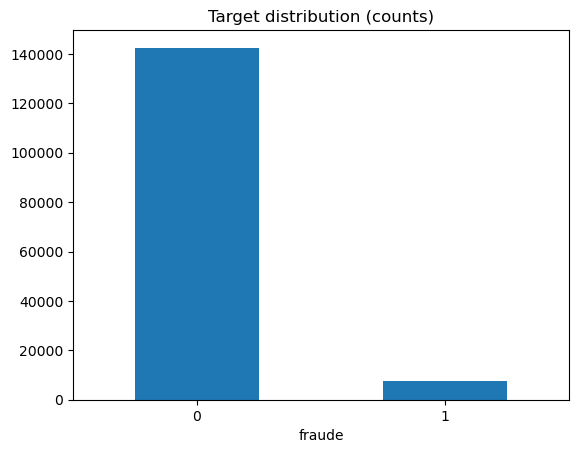

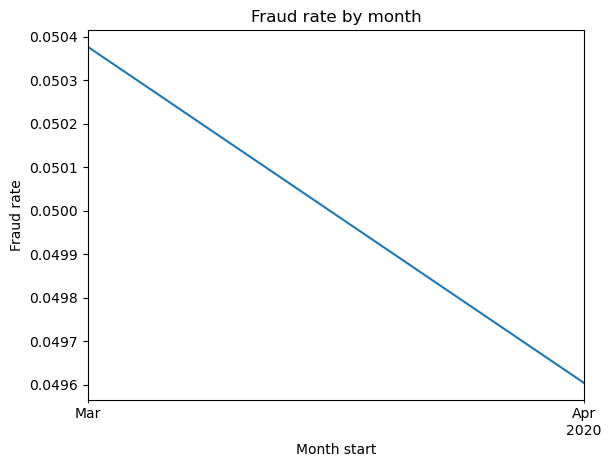

In [36]:
if TARGET_COL in df.columns:
    vc = df[TARGET_COL].value_counts().sort_index()
    display(vc)
    print("Fraud ratio:", (df[TARGET_COL]==1).mean())

    plt.figure()
    vc.plot(kind="bar", rot=0)
    plt.title("Target distribution (counts)")
    plt.show()

    if DATE_COL in df.columns and pd.api.types.is_datetime64_any_dtype(df[DATE_COL]):
        by_month = df.set_index(DATE_COL).resample("MS")[TARGET_COL].mean()
        plt.figure()
        by_month.plot()
        plt.title("Fraud rate by month")
        plt.xlabel("Month start")
        plt.ylabel("Fraud rate")
        plt.show()

> ### Observaciones – Balance de la variable objetivo

**fuerte desbalance**, lo sabiamos:
  - 142,500 casos negativos (95%).
  - 7,500 casos positivos (5%).

- Ya descartamos metricas como **accuracy**.
  vamos con algo como **AUC-PR**, ademas de la metrica de negocio en **funcion de ganancias/perdidas**.

- La tasa de fraude por mes se mantiene **estable en torno al 5%** durante el período analizado (marzo–abril 2020).  
  No se observa una tendencia creciente o decreciente marcada en el corto plazo.

- Conclusion: El gran desbalance seguro va a requerir estratificacion, oversampling/undersampling, y buena calibracion de thresholds.


## 4) Amount (`monto`)

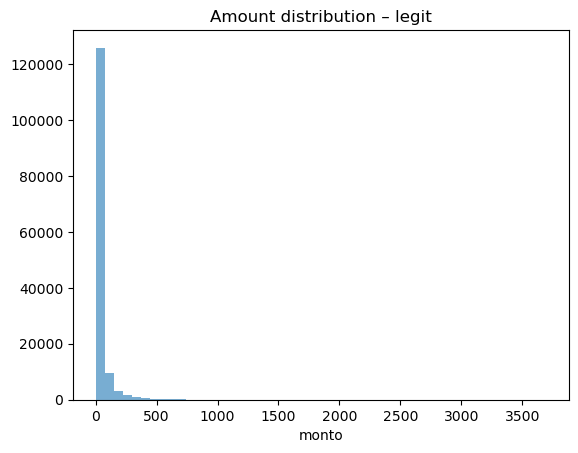

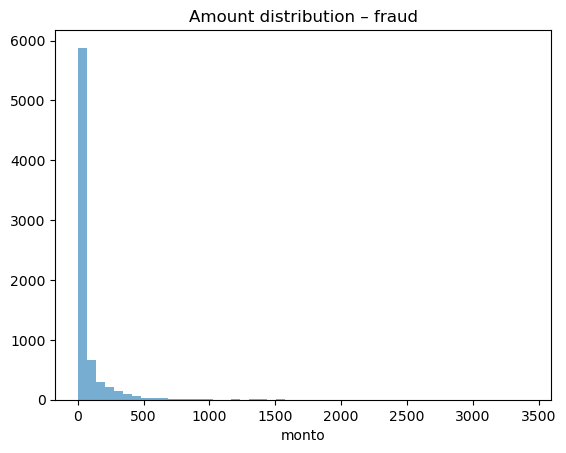

<Figure size 640x480 with 0 Axes>

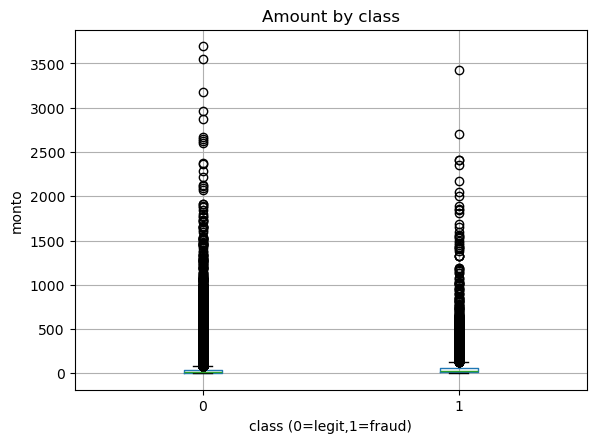

,count,mean,median,min,max
fraude,,,,,
0,142500,41.973326,20.18,0.02,3696.35
1,7500,72.969483,25.87,0.21,3424.81


,p25,p75
fraude,,
0,9.30,40.0225
1,10.82,59.0575


In [45]:
# Busquemos tendencias con Amount
if AMOUNT_COL in df.columns and TARGET_COL in df.columns:
    df0 = df[df[TARGET_COL]==0][AMOUNT_COL].dropna() # casos no fraude
    df1 = df[df[TARGET_COL]==1][AMOUNT_COL].dropna() # casos fraudulentos

    plt.figure()
    plt.hist(df0, bins=50, alpha=0.6)
    plt.title("Amount distribution – legit")
    plt.xlabel("monto")
    plt.show()

    plt.figure()
    plt.hist(df1, bins=50, alpha=0.6)
    plt.title("Amount distribution – fraud")
    plt.xlabel("monto")
    plt.show()

    plt.figure() # para outliers
    df.boxplot(column=AMOUNT_COL, by=TARGET_COL)
    plt.suptitle("")
    plt.title("Amount by class")
    plt.xlabel("class (0=legit,1=fraud)")
    plt.ylabel("monto")
    plt.show()

    stats = df.groupby(TARGET_COL)[AMOUNT_COL].agg(["count","mean","median","min","max"]).copy()
    q = df.groupby(TARGET_COL)[AMOUNT_COL].quantile([0.25,0.75]).unstack()
    display(stats)
    display(q.rename(columns={0.25:"p25",0.75:"p75"}))

> ### Observaciones – Analisis de `monto`

- La distribucion de `monto` es **altamente sesgada a la derecha** en ambas clases: la mayoria de las transacciones se concentran en valores bajos (<500), con colas largas hacia montos altos.

- Al comparar clases:
  - **Fraudes** presentan montos mas altos en promedio (media ≈ 73 vs 42 en no fraude).  
  - Tambien la mediana es mayor (26 vs 20).  
  - Los percentiles 25–75 muestran un rango desplazado hacia arriba en fraudes (10–59) respecto a no fraudes (9–40).

- El box plot evidencia que **los fraudes tienden a ocurrir en montos mayores al tipico de transacciones legitimas**.  
  Esto podria reflejar una estrategia de maximizacion de beneficio por parte de los atacantes.

- Conclusion: `monto` es un feature **altamente discriminativo**, aunque con necesidad de transformaciones, lo mas seguro es que lo pase a escala logaritmica para estabilizar la varianza y mejorar el modelado.


## 5) Score

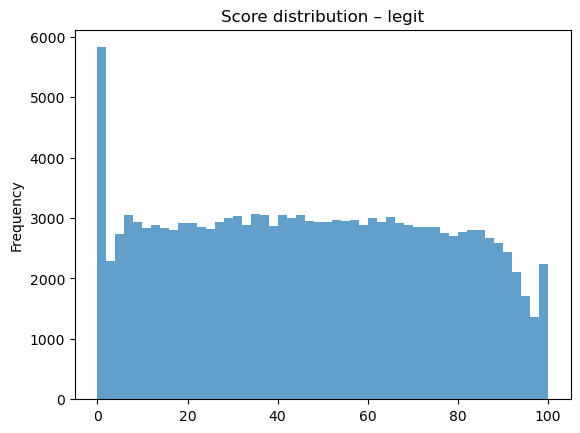

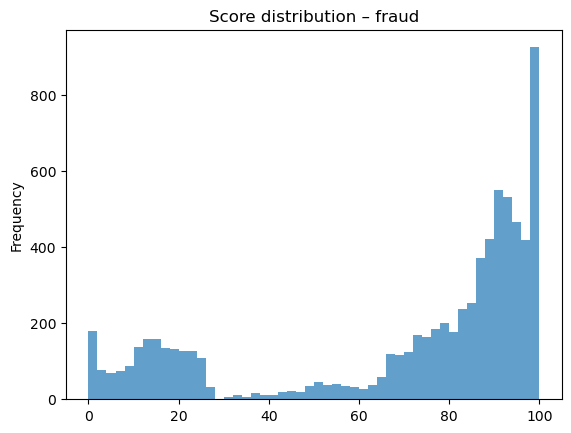

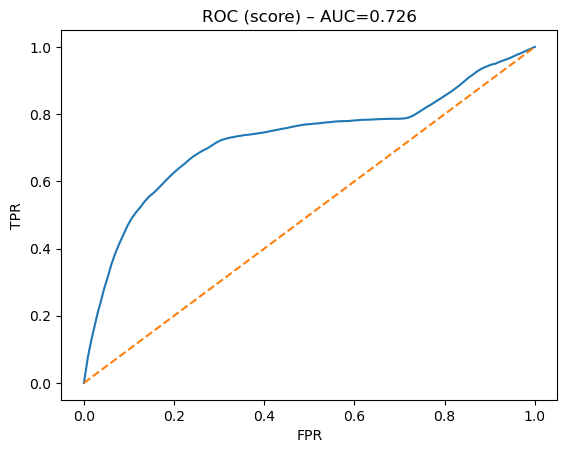

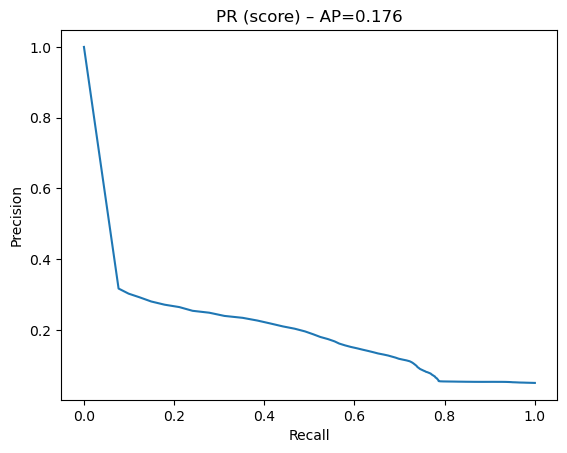

ROC-AUC(score)=0.7263  |  PR-AUC(score)=0.1765


In [52]:
# Score suele tener buen valor por si sola, si es lo que creo que es, investiguemos
if SCORE_COL in df.columns and TARGET_COL in df.columns:
    plt.figure()
    df[df[TARGET_COL]==0][SCORE_COL].dropna().plot(kind="hist", bins=50, alpha=0.7)
    plt.title("Score distribution – legit")
    plt.show()

    plt.figure()
    df[df[TARGET_COL]==1][SCORE_COL].dropna().plot(kind="hist", bins=50, alpha=0.7)
    plt.title("Score distribution – fraud")
    plt.show()

    y_true = df[TARGET_COL].values
    y_score = df[SCORE_COL].values

    mask = ~np.isnan(y_score) & ~np.isnan(y_true)
    y_true = y_true[mask].astype(int)
    y_score = y_score[mask].astype(float)

    if y_true.size > 0:
        fpr, tpr, _ = roc_curve(y_true, y_score)
        prec, rec, _ = precision_recall_curve(y_true, y_score)
        roc_auc = roc_auc_score(y_true, y_score)
        pr_auc = average_precision_score(y_true, y_score)

        plt.figure()
        plt.plot(fpr, tpr)
        plt.plot([0,1],[0,1], linestyle="--")
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.title(f"ROC (score) – AUC={roc_auc:.3f}")
        plt.show()

        plt.figure()
        plt.plot(rec, prec)
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title(f"PR (score) – AP={pr_auc:.3f}")
        plt.show()

        print(f"ROC-AUC(score)={roc_auc:.4f}  |  PR-AUC(score)={pr_auc:.4f}")

> ### Observaciones – Analisis de `score`

  - **Legitimos**: distribucion casi uniforme en todo el rango (0–100), con un pico inicial en 0.  
  - **Fraudes**: concentracion clara en los valores altos (80–100), pero tambien un grupo menor en la zona baja (<20).  
  - Se observa un **valle en la zona media (20–60)**, lo que indica que esta variable separa bien en los extremos pero menos en valores intermedios.

- Metricas predictivas usando solo `score`:
  - **ROC-AUC = 0.726** → desempeño moderado, aporta señal discriminativa.  
  - **PR-AUC = 0.176** → refleja la dificultad del desbalance, pero aun asi es mejor que el azar (≈0.05).

- Conclusion: `score` es una variable relevante y podria ser usada como baseline o como feature en el modelo final.
  Su estructura en extremos sugiere que podria ser aun mas util en combinacion con otros atributos para afinar la clasificacion en la zona “gris”.


## 6) Categorical signals (`g, j, o, p`)


=== g ===


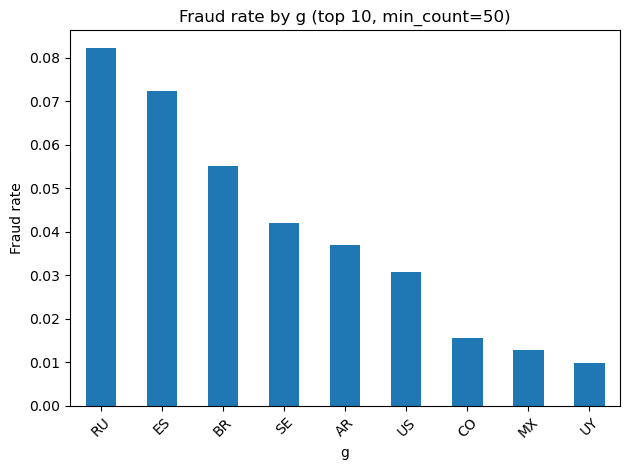

,count,fraud_rate
g,,
AR,31964,0.036885
BR,111628,0.055201
CO,64,0.015625
ES,69,0.072464
MX,236,0.012712
RU,73,0.082192
SE,358,0.041899
US,2273,0.030796
UY,2967,0.009774



=== j ===


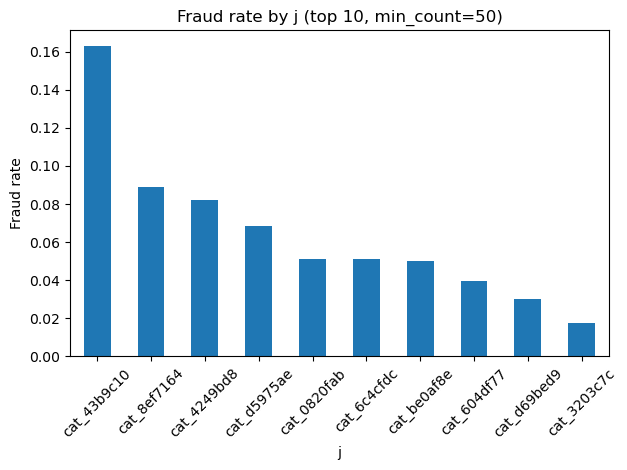

,count,fraud_rate
j,,
cat_0820fab,938,0.051173
cat_3203c7c,1093,0.017383
cat_4249bd8,1191,0.082284
cat_43b9c10,2331,0.163020
cat_604df77,1784,0.039798
cat_6c4cfdc,1449,0.051070
cat_8ef7164,909,0.089109
cat_be0af8e,1040,0.050000
cat_d5975ae,878,0.068337



=== o ===


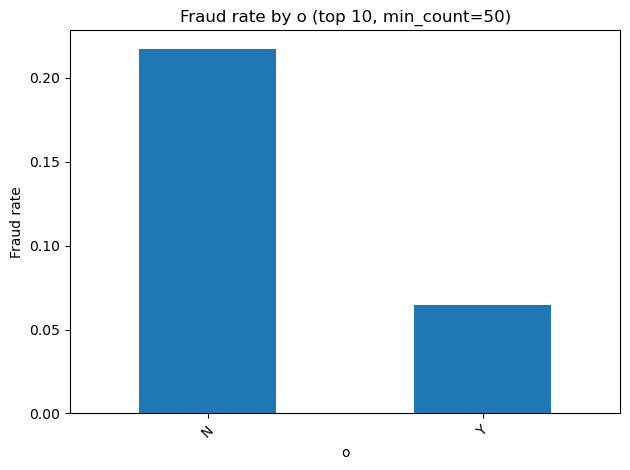

,count,fraud_rate
o,,
N,17052,0.217511
Y,24091,0.064505



=== p ===


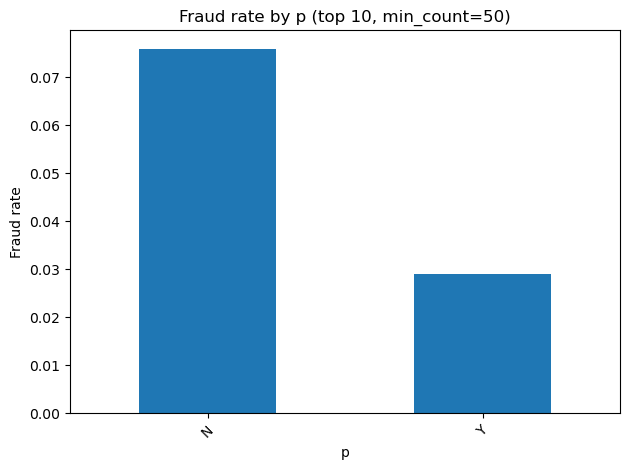

,count,fraud_rate
p,,
N,66871,0.075952
Y,83129,0.029123


In [59]:
# Estan tienen cardinalidades a tratar, nulls y otros temas que tengo que decidir por eso decidi expandir a pesar de tener poco tiempo
def plot_rate_by_category(df, cat_col, target_col, top_n=10, min_count=50):
    vc = df[cat_col].value_counts().head(top_n).index
    sub = df[df[cat_col].isin(vc)]
    counts = sub.groupby(cat_col)[target_col].count()
    rates = sub.groupby(cat_col)[target_col].mean()
    valid = counts[counts >= min_count].index
    counts = counts.loc[valid]
    rates = rates.loc[valid]

    plt.figure()
    rates.sort_values(ascending=False).plot(kind="bar", rot=45)
    plt.title(f"Fraud rate by {cat_col} (top {top_n}, min_count={min_count})")
    plt.ylabel("Fraud rate")
    plt.tight_layout()
    plt.show()
    return counts, rates

for col in ["g", "j", "o", "p"]:
    if col in df.columns and TARGET_COL in df.columns:
        print(f"\n=== {col} ===")
        cnt, rate = plot_rate_by_category(df, col, TARGET_COL, top_n=10, min_count=50)
        display(pd.DataFrame({'count': cnt, 'fraud_rate': rate}))

> ### Observaciones – Señales categóricas

- **`g` (pais)**: diferencias notables en tasas de fraude (ej. RU 8.2% vs UY 0.9%).  
  Se conservara, agrupando paises poco frecuentes en una categoria “Other”.

- **`j` (identificador hash)**: alta cardinalidad pero con categorías muy discriminativas (ej. `cat_43b9c10` con 16%).  
  Se optara por **target encoding con smoothing** para capturar señal y cuidar el riesgo de overfitting.

- **`o`**: presenta un **72% de valores nulos** y, ademas, la mayoria de los fraudes se concentran en los registros sin informacion.  
  Al no contar con contexto de negocio ni garantia de captura futura, se decide **descartar esta variable** por riesgo de ruido.

- **`p`**: variable binaria balanceada con señal clara (N → 7.6% fraude vs Y → 2.9%).  
  Se conservara como indicador 0/1.

- Conclusion: se prioriza **g, j y p** como variables categoricas utiles, descartando `o` por problemas de completitud y confiabilidad.


## 7) Correlations (numerical features)

,a,b,c,d,e,f,h,k,l,m,n,monto,score,fraude
a,1.000000,0.065705,-0.186940,0.007899,0.013226,-0.005113,0.044487,-0.001389,-0.021607,0.002317,0.012586,-0.097154,-0.116879,-0.059681
b,0.065705,1.000000,0.084334,0.001629,-0.013116,-0.022544,-0.045012,-0.002530,-0.036950,-0.027195,-0.014340,0.091681,-0.031137,0.038919
c,-0.186940,0.084334,1.000000,0.000748,-0.010677,-0.002630,0.019240,-0.000061,-0.019677,-0.001644,-0.009291,0.187562,0.023682,0.033229
d,0.007899,0.001629,0.000748,1.000000,-0.001561,0.007553,0.020705,0.002085,0.062535,0.588056,0.174997,-0.023563,-0.128526,-0.077807
e,0.013226,-0.013116,-0.010677,-0.001561,1.000000,0.010515,0.002831,-0.000344,-0.004350,-0.003419,-0.003348,-0.031795,-0.000289,-0.002261
f,-0.005113,-0.022544,-0.002630,0.007553,0.010515,1.000000,-0.000668,-0.001441,0.069055,0.023066,0.022462,0.002644,-0.019725,-0.010489
h,0.044487,-0.045012,0.019240,0.020705,0.002831,-0.000668,1.000000,-0.003904,-0.002159,0.016653,0.007981,-0.068158,-0.020393,-0.034864
k,-0.001389,-0.002530,-0.000061,0.002085,-0.000344,-0.001441,-0.003904,1.000000,0.001945,0.001315,0.001801,-0.001690,0.001370,0.002395
l,-0.021607,-0.036950,-0.019677,0.062535,-0.004350,0.069055,-0.002159,0.001945,1.000000,0.187340,0.310626,0.021639,-0.197709,-0.117023
m,0.002317,-0.027195,-0.001644,0.588056,-0.003419,0.023066,0.016653,0.001315,0.187340,1.000000,0.207430,-0.003798,-0.151841,-0.093437


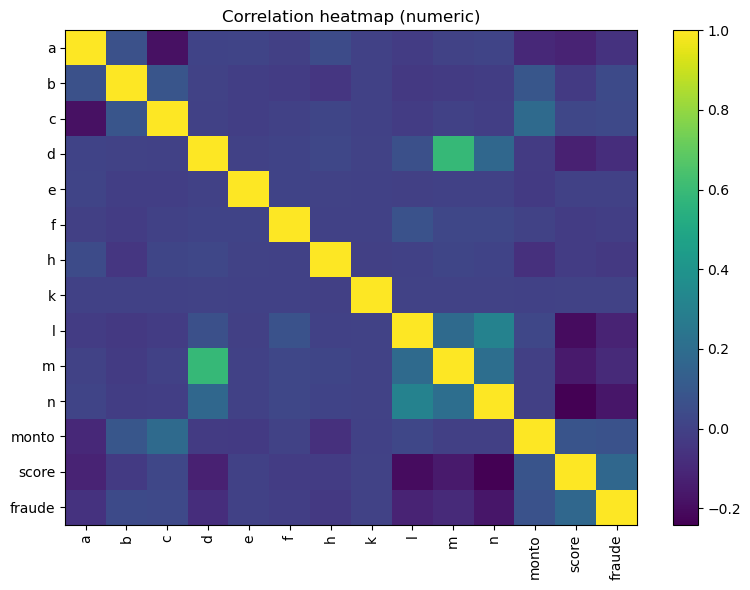

,abs_corr_with_target
score,0.172737
n,0.167728
l,0.117023
m,0.093437
d,0.077807
monto,0.073784
a,0.059681
b,0.038919
h,0.034864
c,0.033229


In [66]:
# Clasico, mas que tengo un par con riesgo de multicolinealidad (b y c)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if AMOUNT_COL in df.columns and AMOUNT_COL not in num_cols:
    try:
        df[AMOUNT_COL] = pd.to_numeric(df[AMOUNT_COL], errors="coerce")
        if AMOUNT_COL not in num_cols:
            num_cols.append(AMOUNT_COL)
    except Exception:
        pass

if num_cols:
    corr = df[num_cols].corr()
    display(corr)

    plt.figure(figsize=(8,6))
    plt.imshow(corr, aspect="auto", interpolation="nearest")
    plt.colorbar()
    plt.xticks(range(len(num_cols)), num_cols, rotation=90)
    plt.yticks(range(len(num_cols)), num_cols)
    plt.title("Correlation heatmap (numeric)")
    plt.tight_layout()
    plt.show()

    if TARGET_COL in num_cols:
        target_corr = corr[TARGET_COL].drop(TARGET_COL).abs().sort_values(ascending=False).head(10)
        display(pd.DataFrame({"abs_corr_with_target": target_corr}))

> ### Observaciones – Correlaciones numericas

- Las correlaciones entre variables numericas son en general **bajas**, sin grupos de colinealidad extrema.  
- Las variables con mayor correlacion con la clase objetivo son:
  - **score** (0.17)  
  - **n** (0.17)  
  - **l** (0.12)  
  - El resto se encuentra por debajo de 0.10.
- A pesar de que las variables `b` y `c` comparten el mismo patron de nulos, sus valores no presentan correlacion fuerte ni entre si ni con el objetivo.
  seguro la relacio vienen del proceso de captura, no tienen signal redundancy.
- Conclusion: no se observan riesgos importantes de multicolinealidad, sobre todo b y que es la razon de estudiar correlacion ya que vamos directo directo a los algoritmos de boosting que pueden manejar estas relaciones de manera nativa sin necesidad de VIF o reduccion adicional.


## 8) Time trends

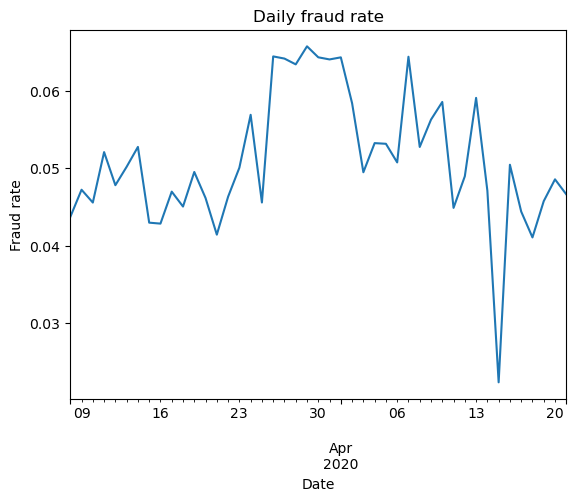

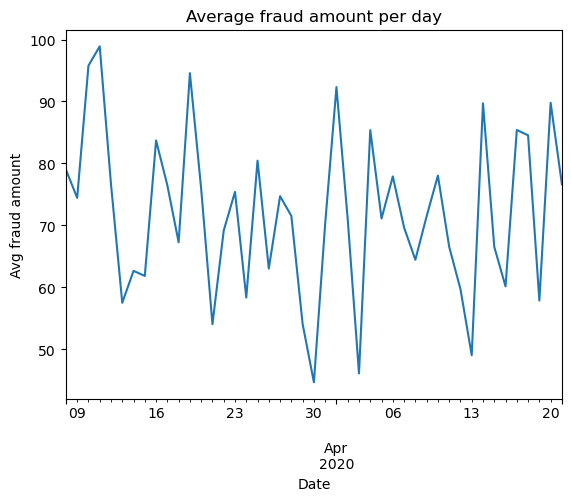

In [69]:
# Siempre hay que chequear, por mas que en la muestra no tenga periodos representativos
if DATE_COL in df.columns and TARGET_COL in df.columns and pd.api.types.is_datetime64_any_dtype(df[DATE_COL]):
    daily = df.set_index(DATE_COL)[TARGET_COL].resample("D").mean()
    plt.figure()
    daily.plot()
    plt.title("Daily fraud rate")
    plt.xlabel("Date")
    plt.ylabel("Fraud rate")
    plt.show()

    if AMOUNT_COL in df.columns:
        daily_amt = df.set_index(DATE_COL).groupby(pd.Grouper(freq="D")).apply(
            lambda x: x.loc[x[TARGET_COL]==1, AMOUNT_COL].mean()
        )
        plt.figure()
        daily_amt.plot()
        plt.title("Average fraud amount per day")
        plt.xlabel("Date")
        plt.ylabel("Avg fraud amount")
        plt.show()

> ### Observaciones – Tendencias temporales

- El analisis temporal cubre unicamente ~1.5 meses (marzo–abril 2020).  
  Este horizonte es demasiado corto para identificar patrones estacionales solidos.

- Aun asi, se observa cierta **variabilidad diaria** en la tasa de fraude (≈4–6.5%), con picos aislados hacia fines de marzo y principios de abril.  
- El **monto promedio de fraudes por día** fluctua de forma marcada, sin tendencia clara.

- Conclusion: los resultados sugieren que puede haber episodios puntuales de fraude más intensos, pero no existe suficiente ventana temporal para confirmarlo.  
  En un escenario real seria imprescindible contar con **multiples meses o años de datos** para estudiar estacionalidad y construir validaciones temporales robustas.

---
## Conclusiones EDA

- Se identifico un **desbalance de clases extremo** (95% legitimas vs 5% fraude).  
  Esto obliga a evaluar modelos con metricas como **AUC-PR** y con umbrales ajustados segun costo/beneficio.

- Variables identificadas como las mas relevantes:
  - **monto**: fraudes tienden a ser de mayor valor → se aplicara transformacion logaritmica.  
  - **score**: aporta señal clara, especialmente en extremos → mantener.  
  - **g (pais)**: diferencias marcadas en tasas de fraude → conservar, agrupando paises raros.  
  - **j (categoria hash)**: alta cardinalidad con categorías muy discriminativas → usar target encoding.  
  - **p**: binaria con señal clara → mantener.  
  - **o**: 72% de nulos y sin contexto → descartar.

- Variables numericas adicionales (`a–m`) presentan correlaciones bajas con el objetivo, pero se incluiran para dar oportunidad al modelo a capturar interacciones.

- Tendencias temporales no muestran patrones robustos dado el corto horizonte (1.5 meses).  
  En un escenario real, se requeriria ampliar la ventana temporal.

### Proximos pasos
1. Definir reglas de limpieza y encoding segun lo observado.  
2. Implementar un pipeline de features (transformaciones y escalado).  
3. Entrenar modelos de boosting (XGBoost, LightGBM) con búsqueda tuneo de hiperparametros (Optuna).  
4. Evaluar con **AUC-PR** y una metrica de **ganancia/costo ajustada a umbrales**.  
5. Calibrar probabilidades (ej. isotonic regression) para mejorar decisiones operativas.
